<div >
<img src = "../banner.jpg" />
</div>

# Spatial Data

In [1]:
require("pacman")
p_load("tidyverse","sf","modeldata","geojsonio")

Loading required package: pacman



In [2]:
data("ames", package = "modeldata")

In [3]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


In [4]:
dim(ames)

[1] 2930   74

In [5]:
class(ames)

[1] "tbl_df"     "tbl"        "data.frame"

![](figs/mercator.gif)

In [6]:
ames_sf <- sf::st_as_sf(
  ames,
  # "coords" is in x/y order -- so longitude goes first!
  coords = c("Longitude", "Latitude"),
  remove=FALSE,
  # Set our coordinate reference system to EPSG:4326,
  # the standard WGS84 geodetic coordinate reference system
  crs = 4326
)

In [7]:
#?st_as_sf

In [8]:
class(ames_sf)

[1] "sf"         "tbl_df"     "tbl"        "data.frame"

In [9]:
head(ames_sf)

MS_SubClass                         MS_Zoning                Lot_Frontage
1 One_Story_1946_and_Newer_All_Styles Residential_Low_Density  141         
2 One_Story_1946_and_Newer_All_Styles Residential_High_Density  80         
3 One_Story_1946_and_Newer_All_Styles Residential_Low_Density   81         
4 One_Story_1946_and_Newer_All_Styles Residential_Low_Density   93         
5 Two_Story_1946_and_Newer            Residential_Low_Density   74         
6 Two_Story_1946_and_Newer            Residential_Low_Density   78         
  Lot_Area Street Alley           Lot_Shape          Land_Contour Utilities
1 31770    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
2 11622    Pave   No_Alley_Access Regular            Lvl          AllPub   
3 14267    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
4 11160    Pave   No_Alley_Access Regular            Lvl          AllPub   
5 13830    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
6  9978    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
  Lot_Config ⋯ Misc_Feature Misc_Val Mo_Sold Year_Sold Sale_Type Sale_Condition
1 Corner     ⋯ None             0    5       2010      WD        Normal        
2 Inside     ⋯ None             0    6       2010      WD        Normal        
3 Corner     ⋯ Gar2         12500    6       2010      WD        Normal        
4 Corner     ⋯ None             0    4       2010      WD        Normal        
5 Inside     ⋯ None             0    3       2010      WD        Normal        
6 Inside     ⋯ None             0    6       2010      WD        Normal        
  Sale_Price Longitude Latitude geometry                  
1 215000     -93.61975 42.05403 POINT (-93.61975 42.05403)
2 105000     -93.61976 42.05301 POINT (-93.61976 42.05301)
3 172000     -93.61939 42.05266 POINT (-93.61939 42.05266)
4 244000     -93.61732 42.05125 POINT (-93.61732 42.05125)
5 189900     -93.63893 42.06090 POINT (-93.63893 42.0609) 
6 195500     -93.63893 42.06078 POINT (-93.63893 42.06078)

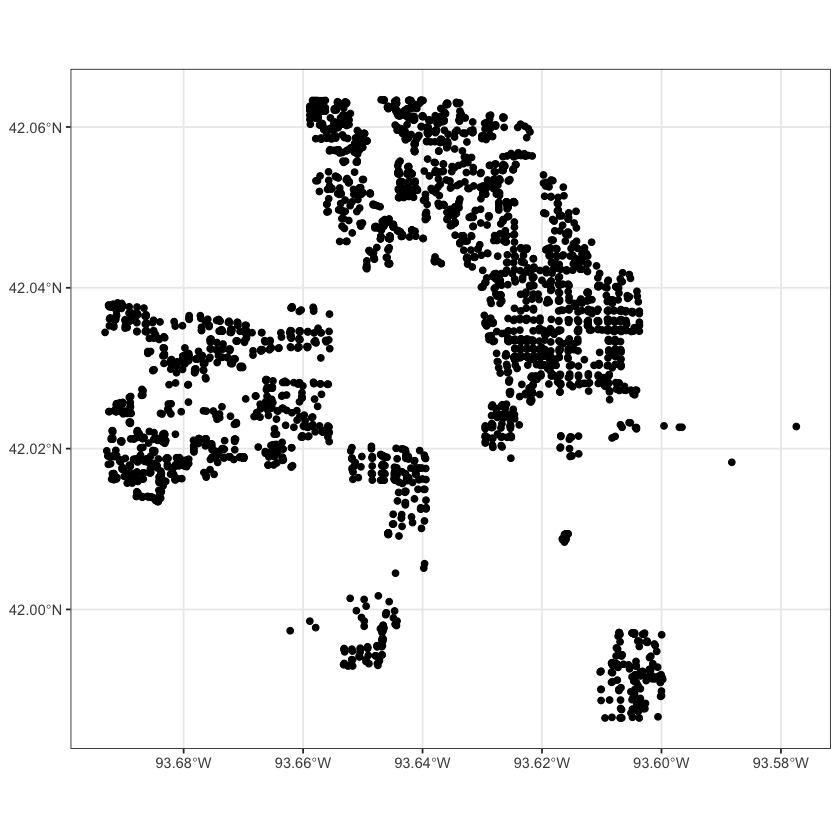

In [10]:
#graficar con ggplot
ggplot() +
    geom_sf(data=ames_sf)+
    theme_bw()

In [11]:
p_load("leaflet")

In [12]:
map1<-leaflet()  %>% 
        addTiles()  %>% 
        addCircleMarkers(data=ames_sf)
map1

HTML widgets cannot be represented in plain text (need html)

In [13]:
#workaround to show in Jupyter Notebook (not needed in Rstudio)
p_load("htmlwidgets","IRdisplay")

saveWidget(map1, 'demo1.html', selfcontained = FALSE)
display_html('<iframe src="demo1.html" width="800" height="800"></iframe>')

In [14]:
#Different Tiles
map2<-leaflet()  %>% 
    addProviderTiles(providers$Stamen.Toner)  %>% 
    addCircles(data=ames_sf)

In [15]:
#workaround to show in Jupyter Notebook (not needed in Rstudio)
p_load("htmlwidgets","IRdisplay")

saveWidget(map2, 'demo2.html', selfcontained = FALSE)
display_html('<iframe src="demo2.html" width="800" height="800"></iframe>')

# Clustering
## Etapas

Las etapas del análisis de clusters podemos resumirlas de la siguiente forma:

1. Iniciamos con una matriz de datos

    \begin{align}
X_{n\times k}=\left(\begin{array}{cccc}
x_{11} &  & \dots & x_{1k}\\
\\
\vdots &  & x_{ik} & \vdots\\
\\
x_{n1} &  & \dots & x_{nk} 
\end{array}\right)
    \end{align}

2. Calculamos la matriz de distancia o disimilitud

\begin{align}
D_{n\times n}=\left(\begin{array}{ccccc}
d_{11} &  & \dots &  & d_{1n}\\
 & \ddots\\
\vdots &  & d_{jj} &  & \vdots\\
 &  &  & \ddots\\
d_{n1} &  & \dots &  & d_{nn}
\end{array}\right)
\end{align}


3. Aplicamos el algoritmo de clustering. Existen varios tipos, en esta módulo nos centramos en aquellos  **Algoritmos basados en centroides**. En estos algoritmos cluster está representado por un centroide. Los clusters se construyen en función de la distancia al centroide del grupo.

In [16]:
set.seed(101011)
ames_sample<-ames_sf  %>% sample_frac(size=1/3)  #una fracción de los datos para rapidez en clase, usted use todos
db<- ames_sample  %>%  select(geometry) #me quedo sólo con la geometría
head(db)

geometry
<POINT [°]>
POINT (-93.61843 42.03981)
POINT (-93.60064 41.99282)
POINT (-93.65627 42.0633)
POINT (-93.64717 42.04741)
POINT (-93.68144 42.01627)
POINT (-93.68496 42.02199)


In [17]:
db<-st_distance(db) #matriz de distancias
head(db)

Units: [m]
         [,1]     [,2]     [,3]     [,4]      [,5]      [,6]     [,7]     [,8]
[1,]    0.000 5427.658 4073.055 2518.941 5825.6619 5841.5591 1510.612 1611.668
[2,] 5427.658    0.000 9085.296 7184.221 7167.6837 7685.3927 6906.400 7033.275
[3,] 4073.055 9085.296    0.000 1921.100 5627.5895 5168.5484 2717.986 2770.083
[4,] 2518.941 7184.221 1921.100    0.000 4471.9924 4210.6710 1707.292 1902.218
[5,] 5825.662 7167.684 5627.589 4471.992    0.0000  699.5592 5957.744 6186.400
[6,] 5841.559 7685.393 5168.548 4210.671  699.5592    0.0000 5794.237 6017.105
         [,9]    [,10]     [,11]     [,12]     [,13]     [,14]     [,15]
[1,] 2374.887 1291.040  923.7357  888.2099 6466.3955 3350.2410 5587.1752
[2,] 7622.742 6697.511 5831.2306 4860.4381 8067.0908 8596.5586  160.8872
[3,] 1746.879 3307.870 3347.6877 4944.6924 5711.1813  983.0459 9244.9819
[4,] 1186.347 2321.911 1636.3247 3400.6278 4831.6279 1746.3548 7343.1574
[5,] 5658.198 6431.639 5071.4725 6384.1873  899.4295 6028.0594 7281.667

In [18]:
db<-units::drop_units(db) #elimina las unidades de la matriz
head(db)

0.000,5427.658,4073.055,2518.941,5825.6619,5841.5591,1510.612,1611.668,2374.887,1291.040,⋯,6223.4573,1823.054,3151.170,3363.6742,6343.1482,4900.299,5105.670,681.1987,6448.4801,3524.0539
5427.658,0.000,9085.296,7184.221,7167.6837,7685.3927,6906.400,7033.275,7622.742,6697.511,⋯,7575.8856,7245.567,4123.768,8419.3505,8368.7216,7542.888,7756.419,6080.1446,7766.4212,8409.4804
4073.055,9085.296,0.000,1921.100,5627.5895,5168.5484,2717.986,2770.083,1746.879,3307.870,⋯,5809.7931,2640.976,5424.455,709.3958,5238.4640,3999.010,4048.131,3693.6288,5958.8643,705.1202
2518.941,7184.221,1921.100,0.000,4471.9924,4210.6710,1707.292,1902.218,1186.347,2321.911,⋯,4766.5481,1931.008,3533.523,1326.4450,4518.3332,3055.840,3202.418,2402.1231,4960.9848,1228.3648
5825.662,7167.684,5627.589,4471.992,0.0000,699.5592,5957.744,6186.400,5658.198,6431.639,⋯,438.8065,6282.979,3470.432,5443.6865,1298.4311,1646.829,1659.357,6181.3113,663.7615,5075.3338
5841.559,7685.393,5168.548,4210.671,699.5592,0.0000,5794.237,6017.105,5388.928,6313.337,⋯,659.4619,6092.321,3816.929,5057.2558,683.3335,1188.389,1121.125,6127.0950,790.3567,4666.3081


In [19]:
k3 <- kmeans(db, centers = 3, nstart = 25)
str(k3)

List of 9
 $ cluster     : int [1:977] 3 1 3 3 2 2 3 3 3 3 ...
 $ centers     : num [1:3, 1:977] 5238 5005 1902 1646 7029 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3] "1" "2" "3"
  .. ..$ : NULL
 $ totss       : num 3.22e+12
 $ withinss    : num [1:3] 8.27e+10 2.93e+11 7.39e+11
 $ tot.withinss: num 1.11e+12
 $ betweenss   : num 2.1e+12
 $ size        : int [1:3] 78 307 592
 $ iter        : int 2
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [20]:
ames_sample<- ames_sample %>% mutate(clusters=factor(k3$cluster))

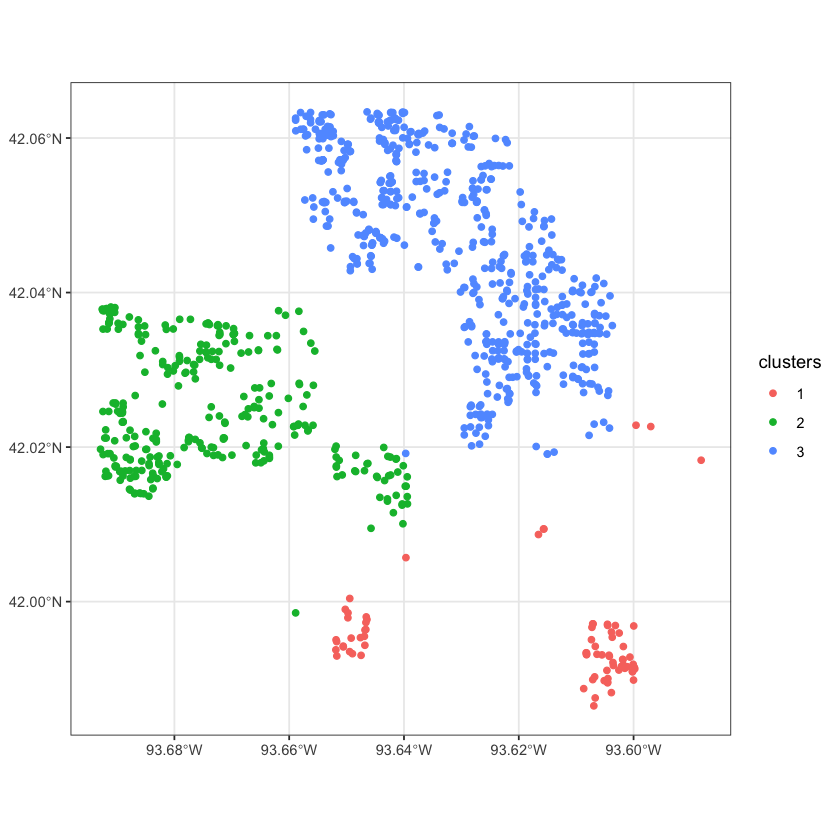

In [21]:
ggplot() +
  geom_sf(data=ames_sample,aes(col=clusters)) + #graficamos las predicciones
  theme_bw()


## Caveat

Los métodos de clustering son exploratorios: se pueden utilizar para evaluar la calidad de los datos y generar hipótesis. 

Pero no importa lo que entre en el algoritmo de agrupamiento, los clusters salen. Esta es una situación clásica de "basura que entra, basura que sale". 



![](figs/Garbage-Model.jpg)



Obviamente, esperamos que lo que se está metiendo en el análisis no sea basura, pero eso no garantiza que salga una "pearl of wisdom".

La conclusión es que la agrupación es buena si es útil para responder el problema en particular. Pero, esto es difícil de evaluar.


Hay medidas de cuán bueno es el agrupamiento. Funcionan según el principio de que las distancias entre los elementos del mismo grupo deben ser pequeñas y las distancias entre los elementos de diferentes grupos deben ser grandes. 

Esta es una verificación interna de la "estrechez" de los grupos, pero no garantiza que los grupos sean útiles y/o significativos para el problema bajo estudio. Esto requiere que el usuario utilice su capacidad y discernimiento.

## ¿Cuántos K (clusters) debemos elegir?

### Método del codo

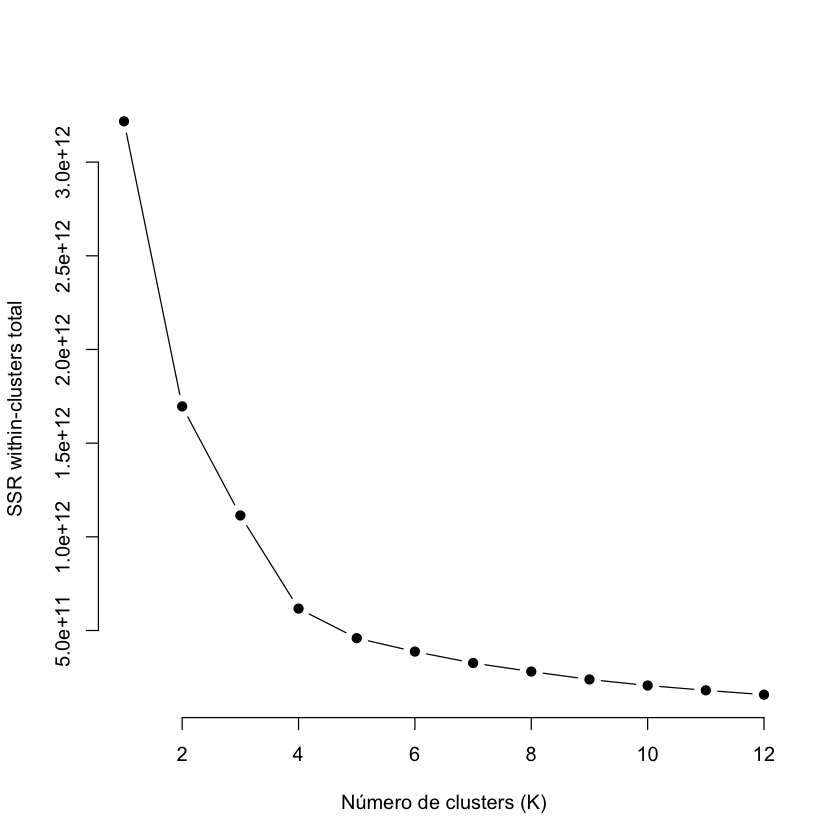

In [22]:
# función que calcula la SSR within-cluster 
wss <- function(k) {
  kmeans(db, k, nstart = 25 )$tot.withinss
}

# Calculamos y graficamos para k = 1 hasta k = 12
wss_values <- sapply(1:12,wss)

plot(1:12, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Número de clusters (K)",
       ylab="SSR within-clusters total")

### Coeficiente de Silhouette

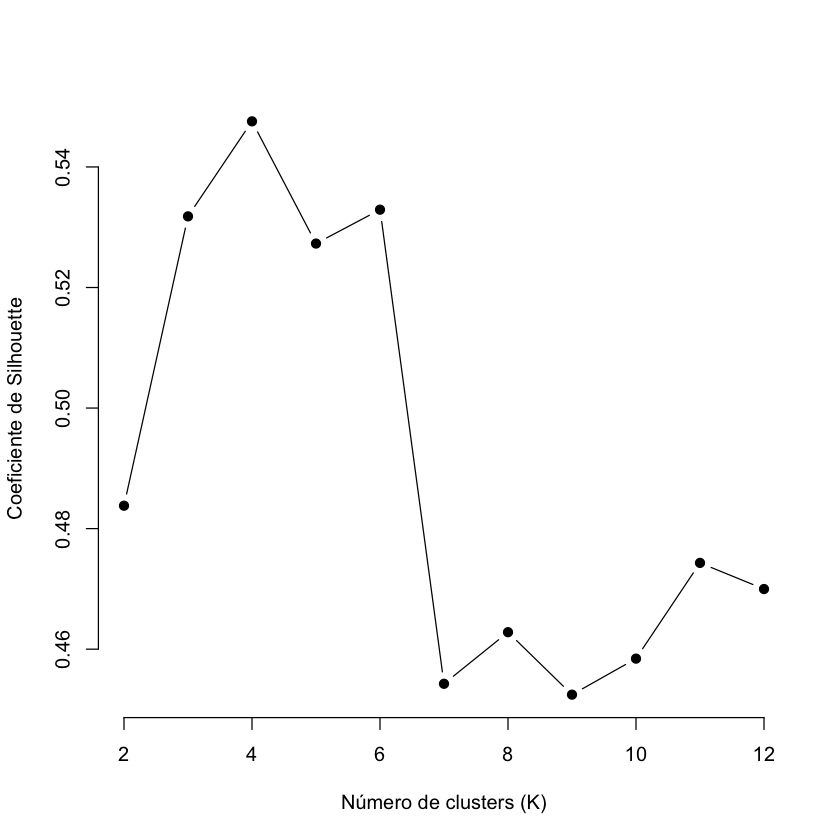

In [23]:
p_load("cluster")
# función para extraer el coeficiente de silhouette

avg_sil <- function(k) {
  km.res <- kmeans(db, centers = k, nstart = 25)
  ss <- cluster::silhouette(km.res$cluster, dist(db))
  mean(ss[, 3])
}


# Calcular el coeficiente de silhouette para  k = 2 hasta k = 12
valores_sil <-  sapply(2:12,avg_sil)

plot(2:12, valores_sil,
       type = "b", pch = 19, frame = FALSE, 
       xlab="Número de clusters (K)",
       ylab = "Coeficiente de Silhouette")

In [24]:
k4 <- kmeans(db, centers = 4, nstart = 25)

ames_sample<- ames_sample %>% mutate(clusters=factor(k4$cluster))

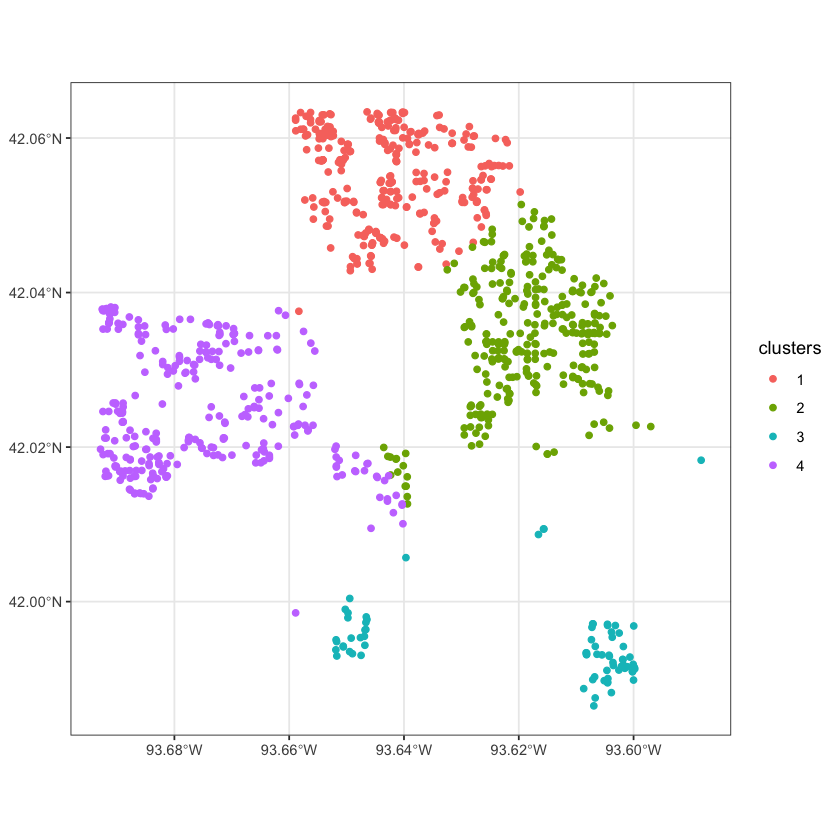

In [25]:
ggplot() +
  geom_sf(data=ames_sample,aes(col=clusters)) + #graficamos las predicciones
  theme_bw()

# Super learner

Vamos a modelar los precios de venta de las casas en el conjunto de datos de Ames. Digamos que el precio de venta de estas casas depende del año en que se construyeron, su superficie habitable (tamaño) y el tipo de casa que son (dúplex vs. townhouse vs. unifamiliar)

In [26]:
ames<- ames  %>% mutate(logprice=log(Sale_Price))

In [27]:
p_load("caret")
set.seed(1011)
inTrain <- createDataPartition(
  y = ames$logprice,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- ames[ inTrain,]
test  <- ames[-inTrain,]
colnames(train)

[1] "MS_SubClass"        "MS_Zoning"          "Lot_Frontage"      
 [4] "Lot_Area"           "Street"             "Alley"             
 [7] "Lot_Shape"          "Land_Contour"       "Utilities"         
[10] "Lot_Config"         "Land_Slope"         "Neighborhood"      
[13] "Condition_1"        "Condition_2"        "Bldg_Type"         
[16] "House_Style"        "Overall_Cond"       "Year_Built"        
[19] "Year_Remod_Add"     "Roof_Style"         "Roof_Matl"         
[22] "Exterior_1st"       "Exterior_2nd"       "Mas_Vnr_Type"      
[25] "Mas_Vnr_Area"       "Exter_Cond"         "Foundation"        
[28] "Bsmt_Cond"          "Bsmt_Exposure"      "BsmtFin_Type_1"    
[31] "BsmtFin_SF_1"       "BsmtFin_Type_2"     "BsmtFin_SF_2"      
[34] "Bsmt_Unf_SF"        "Total_Bsmt_SF"      "Heating"           
[37] "Heating_QC"         "Central_Air"        "Electrical"        
[40] "First_Flr_SF"       "Second_Flr_SF"      "Gr_Liv_Area"       
[43] "Bsmt_Full_Bath"     "Bsmt_Half_Bath"     "Full_Bath"         
[46] "Half_Bath"          "Bedroom_AbvGr"      "Kitchen_AbvGr"     
[49] "TotRms_AbvGrd"      "Functional"         "Fireplaces"        
[52] "Garage_Type"        "Garage_Finish"      "Garage_Cars"       
[55] "Garage_Area"        "Garage_Cond"        "Paved_Drive"       
[58] "Wood_Deck_SF"       "Open_Porch_SF"      "Enclosed_Porch"    
[61] "Three_season_porch" "Screen_Porch"       "Pool_Area"         
[64] "Pool_QC"            "Fence"              "Misc_Feature"      
[67] "Misc_Val"           "Mo_Sold"            "Year_Sold"         
[70] "Sale_Type"          "Sale_Condition"     "Sale_Price"        
[73] "Longitude"          "Latitude"           "logprice"

In [28]:
p_load("SuperLearner")

In [29]:
# Review available models.
listWrappers()

All prediction algorithm wrappers in SuperLearner:




 [1] "SL.bartMachine"      "SL.bayesglm"         "SL.biglasso"        
 [4] "SL.caret"            "SL.caret.rpart"      "SL.cforest"         
 [7] "SL.earth"            "SL.extraTrees"       "SL.gam"             
[10] "SL.gbm"              "SL.glm"              "SL.glm.interaction" 
[13] "SL.glmnet"           "SL.ipredbagg"        "SL.kernelKnn"       
[16] "SL.knn"              "SL.ksvm"             "SL.lda"             
[19] "SL.leekasso"         "SL.lm"               "SL.loess"           
[22] "SL.logreg"           "SL.mean"             "SL.nnet"            
[25] "SL.nnls"             "SL.polymars"         "SL.qda"             
[28] "SL.randomForest"     "SL.ranger"           "SL.ridge"           
[31] "SL.rpart"            "SL.rpartPrune"       "SL.speedglm"        
[34] "SL.speedlm"          "SL.step"             "SL.step.forward"    
[37] "SL.step.interaction" "SL.stepAIC"          "SL.svm"             
[40] "SL.template"         "SL.xgboost"         



All screening algorithm wrappers in SuperLearner:




[1] "All"
[1] "screen.corP"           "screen.corRank"        "screen.glmnet"        
[4] "screen.randomForest"   "screen.SIS"            "screen.template"      
[7] "screen.ttest"          "write.screen.template"


In [30]:
ySL<-train$logprice
XSL<- train  %>% select(Year_Built, Bldg_Type, Gr_Liv_Area)

In [31]:
sl.lib <- c("SL.randomForest", "SL.lm") #lista de los algoritmos a correr

# Fit using the SuperLearner package,

fitY <- SuperLearner(Y = ySL,  X= data.frame(XSL),
                     method = "method.NNLS", # combinación convexa
                     SL.library = sl.lib)

fitY

Loading required namespace: randomForest




Call:  
SuperLearner(Y = ySL, X = data.frame(XSL), SL.library = sl.lib, method = "method.NNLS") 



                          Risk      Coef
SL.randomForest_All 0.04174329 0.5346039
SL.lm_All           0.04248011 0.4653961

In [32]:
test <- test  %>%  mutate(yhat_Sup=predict(fitY, newdata = data.frame(test), onlySL = T)$pred)
head(test$yhat_Sup)

11.72938
12.24929
12.23490
12.08342
12.47830
11.80857


In [33]:
with(test,mean(abs(logprice-yhat_Sup))) #MAE

[1] 0.1461409

## Test algorithm with multiple hyperparameter settings

The performance of an algorithm varies based on its hyperparamters, which again are its configuration settings. Some algorithms may not vary much, and others might have far better or worse performance for certain settings. Often we focus our attention on 1 or 2 hyperparameters for a given algorithm because they are the most important ones.

For random forest there are two particularly important hyperparameters: mtry and maximum leaf nodes. Mtry is how many features are randomly chosen within each decision tree node - in other words, each time the tree considers making a split. Maximum leaf nodes controls how complex each tree can get.

Let's try 3 different mtry options.

In [34]:
# Customize the defaults for random forest.
custon_ranger = create.Learner("SL.ranger", params = list(num.trees = 1000))

# Look at the object.
custon_ranger$names


[1] "SL.ranger_1"

In [35]:
custom_rf = create.Learner("SL.randomForest",
                     tune = list(mtry = round(c(1, sqrt(4), 3))))
custom_rf$names

[1] "SL.randomForest_1" "SL.randomForest_2" "SL.randomForest_3"

In [36]:
# Customize the defaults for random forest.
custon_glmnet = create.Learner("SL.glmnet", tune = list(alpha = seq(0, 1, length.out=5)))

# Look at the object.
custon_glmnet$names

[1] "SL.glmnet_1" "SL.glmnet_2" "SL.glmnet_3" "SL.glmnet_4" "SL.glmnet_5"

In [37]:
sl.lib2 <- c("SL.randomForest", "SL.lm",custon_ranger$names,custon_glmnet$names,custom_rf$names)
sl.lib2

[1] "SL.randomForest"   "SL.lm"             "SL.ranger_1"      
 [4] "SL.glmnet_1"       "SL.glmnet_2"       "SL.glmnet_3"      
 [7] "SL.glmnet_4"       "SL.glmnet_5"       "SL.randomForest_1"
[10] "SL.randomForest_2" "SL.randomForest_3"

In [38]:
# Fit (takes forever)

fitY_long <- SuperLearner(Y = ySL, X = data.frame(XSL),
     method = "method.NNLS", SL.library = sl.lib2)

fitY_long

Loading required namespace: ranger

Loading required namespace: glmnet




Call:  
SuperLearner(Y = ySL, X = data.frame(XSL), SL.library = sl.lib2, method = "method.NNLS") 



                            Risk      Coef
SL.randomForest_All   0.04152517 0.1493768
SL.lm_All             0.04232470 0.3382666
SL.ranger_1_All       0.04519826 0.0000000
SL.glmnet_1_All       0.04266238 0.0000000
SL.glmnet_2_All       0.04232742 0.0000000
SL.glmnet_3_All       0.04232962 0.0000000
SL.glmnet_4_All       0.04233001 0.0000000
SL.glmnet_5_All       0.04233069 0.0000000
SL.randomForest_1_All 0.04191911 0.0000000
SL.randomForest_2_All 0.03959978 0.5123566
SL.randomForest_3_All 0.04153433 0.0000000

# Spatial Cross Validation


In [39]:
p_load("spatialsample")

ames_sf <- sf::st_as_sf(
  ames,
  # "coords" is in x/y order -- so longitude goes first!
  coords = c("Longitude", "Latitude"),
  # Set our coordinate reference system to EPSG:4326,
  # the standard WGS84 geodetic coordinate reference system
  crs = 4326
)


In [40]:
set.seed(123)
block_folds <- spatial_block_cv(ames_sf, v = 15)

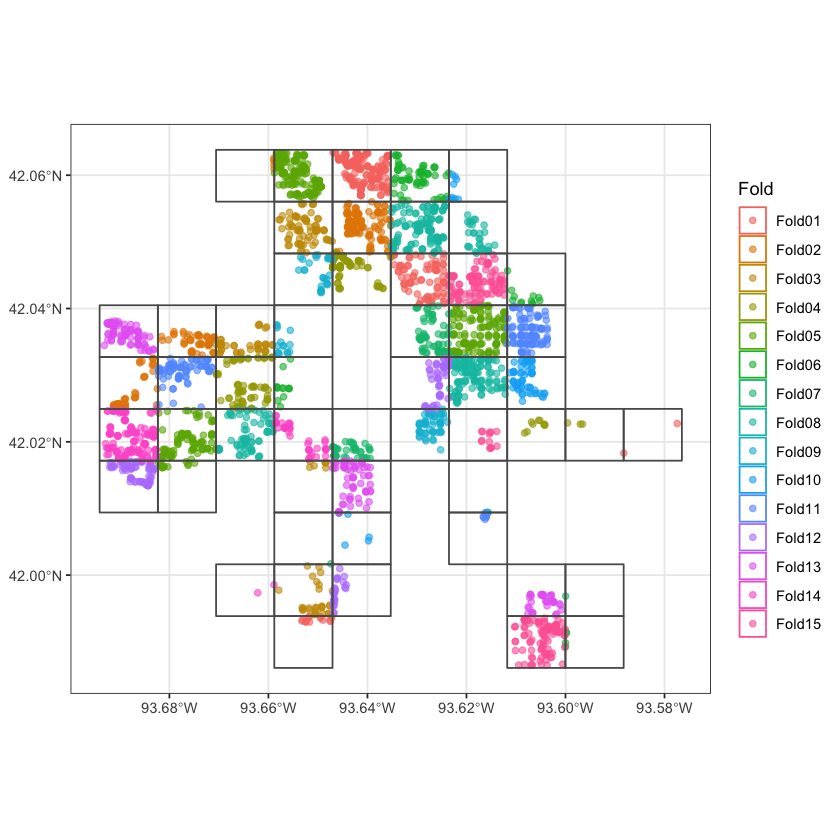

In [41]:
autoplot(block_folds) + theme_bw()

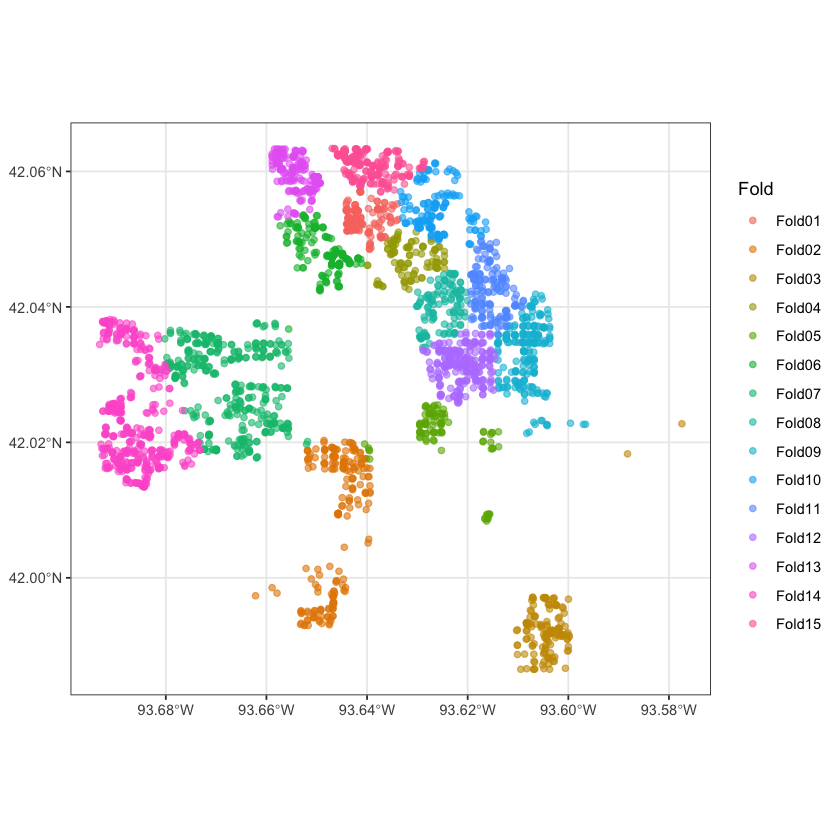

In [42]:

set.seed(123)
cluster_folds <- spatial_clustering_cv(ames_sf, v = 15)
autoplot(cluster_folds) + theme_bw()

In [43]:
set.seed(123)
location_folds <- 
  spatial_leave_location_out_cv(
   ames_sf,
    group = Neighborhood,
    v = 15
  )

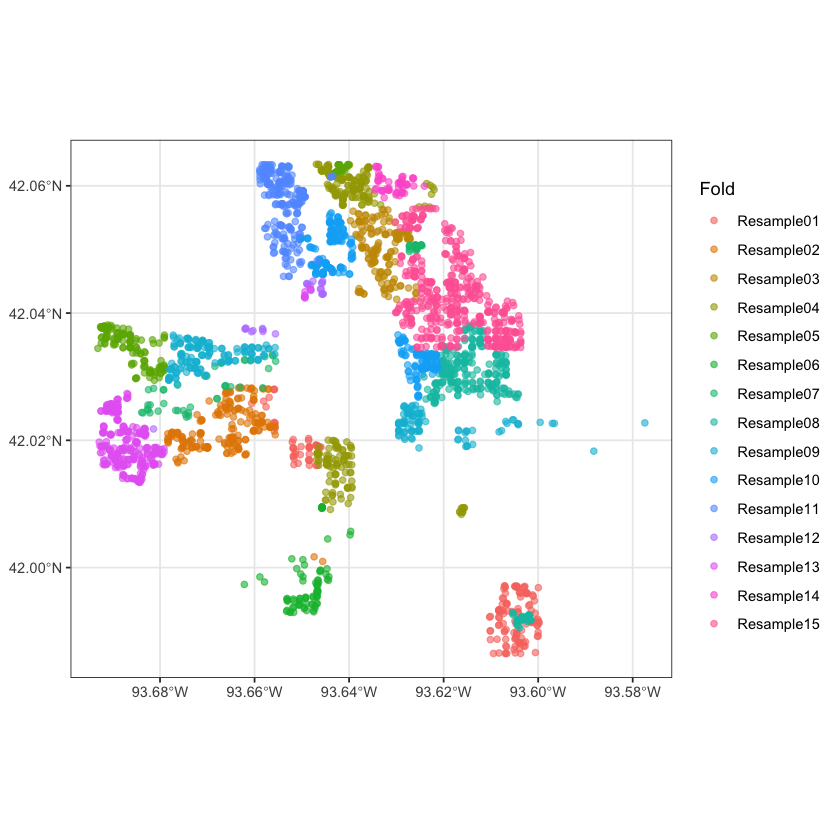

In [44]:
autoplot(location_folds)+ theme_bw()

In [45]:
table(ames_sf$Neighborhood)



                             North_Ames                           College_Creek 
                                    443                                     267 
                               Old_Town                                 Edwards 
                                    239                                     194 
                               Somerset                      Northridge_Heights 
                                    182                                     166 
                                Gilbert                                  Sawyer 
                                    165                                     151 
                         Northwest_Ames                             Sawyer_West 
                                    131                                     125 
                               Mitchell                               Brookside 
                                    114                                     108 
                           

In [46]:
ames_sf <- ames_sf   %>% mutate(Neighborhood=droplevels(Neighborhood))

In [47]:
table(ames_sf$Neighborhood)


                             North_Ames                           College_Creek 
                                    443                                     267 
                               Old_Town                                 Edwards 
                                    239                                     194 
                               Somerset                      Northridge_Heights 
                                    182                                     166 
                                Gilbert                                  Sawyer 
                                    165                                     151 
                         Northwest_Ames                             Sawyer_West 
                                    131                                     125 
                               Mitchell                               Brookside 
                                    114                                     108 
                           

In [48]:
length(unique(ames_sf$Neighborhood))

[1] 28

In [49]:
test_neigh<- ames_sf  %>% filter(Neighborhood=="North_Ames")
test_neigh <- test_neigh   %>% mutate(Neighborhood=droplevels(Neighborhood))
train_neigh<- ames_sf  %>% filter(Neighborhood!="North_Ames")
train_neigh <- train_neigh   %>% mutate(Neighborhood=droplevels(Neighborhood))

In [50]:
y_neigh<-train_neigh$logprice
X_neigh<- train_neigh  %>% select(Year_Built, Bldg_Type, Gr_Liv_Area)  %>% st_drop_geometry()

In [51]:
index <- split(1:nrow(train_neigh),train_neigh$Neighborhood)

In [52]:
index

$College_Creek
  [1]  192  193  194  195  199  200  201  202  203  204  205  206  207  208  209
 [16]  210  211  212  213  214  215  666  667  668  669  670  671  672  673  674
 [31]  675  676  677  678  679  683  684  685  686  687  688  689  690  691  692
 [46]  693  694  695  696  697  698  699  700  701  702  703  704  705  706  707
 [61]  708  709  710  711  712  713  714  715  716  717  718  719  720  721  722
 [76]  723  724  725  726  727  728  729  730  731 1185 1186 1187 1188 1193 1194
 [91] 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
[106] 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224
[121] 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239
[136] 1240 1241 1242 1243 1244 1245 1246 1753 1754 1755 1756 1757 1758 1759 1760
[151] 1761 1762 1763 1764 1765 1766 1767 1768 1769 1776 1777 1778 1779 1780 1781
[166] 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793 1794 1795 1796
[181] 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811
[196] 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821 1822 1823 2308 2309 2310
[211] 2311 2312 2313 2314 2315 2316 2317 2318 2319 2320 2326 2327 2328 2329 2330
[226] 2331 2332 2333 2334 2335 2336 2337 2338 2339 2340 2341 2342 2343 2344 2345
[241] 2347 2348 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2361
[256] 2362 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373

$Old_Town
  [1]  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125
 [16]  126  127  128  129  130  131  132  133  143  144  145  146  147  150  526
 [31]  527  528  529  530  531  532  533  534  535  536  537  538  539  540  541
 [46]  542  543  544  545  546  547  548  549  550  551  552  553  554  555  556
 [61]  557  558  559  560  561  562  563  564  565  566  567  568  569  570  571
 [76]  572  573  597  598  599  600  601  604  605 1040 1041 1042 1043 1044 1045
 [91] 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060
[106] 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075
[121] 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1108 1109
[136] 1118 1119 1120 1128 1129 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631
[151] 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646
[166] 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661
[181] 1678 1683 1684 1685 1686 1697 1698 1699 2181 2182 2183 2184 2185 2186 2187
[196] 2188 2189 2190 2191 2192 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202
[211] 2203 2204 2205 2206 2207 2208 2209 2210 2211 2212 2213 2214 2215 2216 2217
[226] 2218 2219 2220 2221 2222 2223 2224 2225 2226 2232 2240 2244 2246 2247

$Edwards
  [1]  177  178  179  180  181  182  183  184  185  186  216  217  218  219  220
 [16]  221  222  223  224  225  226  227  230  610  611  612  613  614  615  631
 [31]  632  634  635  636  637  638  639  640  641  642  643  644  645  646  732
 [46]  733  734  735  736  737  738  739  740  741  742  743  744  745  746  747
 [61]  748  749  750  751  752 1137 1165 1166 1167 1169 1170 1171 1172 1173 1174
 [76] 1175 1176 1177 1178 1179 1247 1248 1249 1250 1251 1252 1253 1254 1255 1256
 [91] 1257 1258 1259 1260 1261 1262 1263 1264 1265 1266 1267 1268 1269 1270 1271
[106] 1272 1273 1274 1275 1276 1703 1731 1732 1733 1735 1736 1738 1739 1740 1741
[121] 1742 1743 1744 1745 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834
[136] 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849
[151] 1850 2260 2290 2291 2292 2293 2294 2295 2296 2297 2298 2299 2300 2301 2302
[166] 2303 2374 2375 2376 2377 2378 2379 2380 2381 2382 2383 2384 2385 2386 2387
[181] 2388 2389 2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2401 2402

$Somerset
  [1]   19   57   58   59   60   61   62   84   85   86   87   88   89   90   91
 [16]   92   93   94   95   96  100  323  324  325  326  434  435  436  437  438
 [31]  43

In [53]:
folds<-length(index)
folds

[1] 27

In [54]:
fitY_neigh <- SuperLearner(Y = y_neigh, X = data.frame(X_neigh),
    method = "method.NNLS", SL.library = sl.lib,
    cvControl = list(V = folds, validRows = index))

In [55]:
fitY_neigh


Call:  
SuperLearner(Y = y_neigh, X = data.frame(X_neigh), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                          Risk      Coef
SL.randomForest_All 0.05424033 0.4991711
SL.lm_All           0.05421830 0.5008289

In [56]:
yhat_SL_neigh=predict(fitY_neigh, newdata = data.frame(test_neigh), onlySL = T)$pred


In [57]:
with(test_neigh,mean(abs(logprice-yhat_SL_neigh)))

[1] 0.1079064

In [58]:
with(test ,mean(abs(logprice-yhat_Sup)))

[1] 0.1461409